In [0]:
##necessary imports
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
##Getting the data
!wget http://vision.grasp.upenn.edu/video/FLIC-full.zip

--2019-04-24 03:44:18--  http://vision.grasp.upenn.edu/video/FLIC-full.zip
Resolving vision.grasp.upenn.edu (vision.grasp.upenn.edu)... 158.130.68.17
Connecting to vision.grasp.upenn.edu (vision.grasp.upenn.edu)|158.130.68.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1183926041 (1.1G) [application/zip]
Saving to: ‘FLIC-full.zip’

FLIC-full.zip       100%[===================>]   1.10G  35.8MB/s    in 33s     

2019-04-24 03:44:51 (34.6 MB/s) - ‘FLIC-full.zip’ saved [1183926041/1183926041]



In [0]:
##Unzipping the dataset
!unzip FLIC-full.zip

In [0]:
##removing the zip file for saving the space
!rm -rf FLIC-full.zip
print("Zip file removed")
!ls

Zip file removed
FLIC-full  sample_data


In [0]:
##changing the current directory to FLIC-full
cd FLIC-full

/content/FLIC-full


In [0]:
##getting the file which contains the training indices
! wget http://cims.nyu.edu/~tompson/data/tr_plus_indices.mat
##Matlab file   

--2019-04-24 03:46:16--  http://cims.nyu.edu/~tompson/data/tr_plus_indices.mat
Resolving cims.nyu.edu (cims.nyu.edu)... 128.122.49.28
Connecting to cims.nyu.edu (cims.nyu.edu)|128.122.49.28|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cims.nyu.edu/~tompson/data/tr_plus_indices.mat [following]
--2019-04-24 03:46:16--  https://cims.nyu.edu/~tompson/data/tr_plus_indices.mat
Connecting to cims.nyu.edu (cims.nyu.edu)|128.122.49.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34960 (34K) [text/plain]
Saving to: ‘tr_plus_indices.mat’

tr_plus_indices.mat 100%[===================>]  34.14K  --.-KB/s    in 0.09s   

2019-04-24 03:46:16 (399 KB/s) - ‘tr_plus_indices.mat’ saved [34960/34960]



In [0]:
##change the working directory back to original one
cd ..

/content


In [0]:
!ls

FLIC-full  sample_data


In [0]:
##importing other required dependencies
import os
import random
import glob
import h5py
##To load matlab files
from scipy.io import loadmat 
##loading opencv
import cv2 as cv
##loading train_test_split
from sklearn.model_selection import train_test_split

In [0]:
##setting seed for reproduciablity
seed_val = 9000
np.random.seed(seed_val)
random.seed(seed_val)

In [0]:
##Exploring the dataset

##loading the examples file
examples = loadmat('FLIC-full/examples.mat')
print("Type if the file is {}".format(type(examples)))

Type if the file is <class 'dict'>


In [0]:
##we have dictionary lets look at the keys of the dictionary
print("Keys of the dictonary are {}".format(examples.keys()))
## we are interedted in the examples key.

Keys of the dictonary are dict_keys(['__header__', '__version__', '__globals__', 'examples'])


In [0]:
##lets inspect the examples key
##examples['examples'][:2]

##Lets inspect the shape of the examples
print("Shape of the examples key is \n {}".format(examples['examples'].shape))

Shape of the examples key is 
 (1, 20928)


In [0]:
##reshaping the keys
examples = examples['examples'].reshape(-1,)
print("New shape after reshaping {}".format(examples.shape))

New shape after reshaping (20928,)


In [0]:
##example keys contain the IDs of the images and the corrosponding pose coordinates that is to used for modelling.
print(examples[0][2])

##name of the example file is of the format
print()
print(examples[0][3][0])
print()
print(examples[0][2].shape)

[[436.58776855 446.54693604 456.50613403 265.28979492 277.24081421
  380.81634521 434.59591675          nan          nan 325.04492188
           nan          nan 400.73471069 374.84082031          nan
           nan 384.80001831          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan]
 [195.15625    286.796875   322.65625    203.125      328.6328125
  336.6015625  370.46875             nan          nan 386.40625
           nan          nan 129.4140625  125.4296875           nan
           nan 145.3515625           nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan]]

12-oclock-high-special-edition-00004151.jpg

(2, 29)


In [0]:
##name of the 29 points
joint_labels = ['lsho','lelb','lwri','rsho','relb','rwri','lhip','lkne','lank','rhip','rkne','rank','reye','leye','lear','rear',
               'nose','msho','mhip','mear','mtorso','mruarm','mllarm','mrlarm','mluleg','mruleg','mllleg','mrlleg']
joint_labels

['lsho',
 'lelb',
 'lwri',
 'rsho',
 'relb',
 'rwri',
 'lhip',
 'lkne',
 'lank',
 'rhip',
 'rkne',
 'rank',
 'reye',
 'leye',
 'lear',
 'rear',
 'nose',
 'msho',
 'mhip',
 'mear',
 'mtorso',
 'mruarm',
 'mllarm',
 'mrlarm',
 'mluleg',
 'mruleg',
 'mllleg',
 'mrlleg']

In [0]:
##Printing the list of known joints
known_joints = [x for i,x in enumerate(joint_labels) if i in np.r_[0:7,9,12:14,16]]
known_joints

['lsho',
 'lelb',
 'lwri',
 'rsho',
 'relb',
 'rwri',
 'lhip',
 'rhip',
 'reye',
 'leye',
 'nose']

In [0]:
##getting our target joints
target_joints = ['lsho', 'lelb', 'lwri', 'rsho', 'relb',
                 'rwri', 'leye', 'reye', 'nose']
print('Joints necessary for the project:\n', target_joints)

# print the indices of the needed joints in the coordinates array
joints_loc_id = np.r_[0:6, 12:14, 16]
print('\nIndices of joints necessary for the project:\n',joints_loc_id)

Joints necessary for the project:
 ['lsho', 'lelb', 'lwri', 'rsho', 'relb', 'rwri', 'leye', 'reye', 'nose']

Indices of joints necessary for the project:
 [ 0  1  2  3  4  5 12 13 16]


In [0]:
##framing the target joints
def joint_coordinates(joint):
    """
    Store necessary joints as a list.
    agrument:
    joint: List of all the joints
    returns the list of newly created target joints
    """
    ##empty list
    joint_coord = []
    
    ##taking the mean for the eyes and nose
    joint['head'] = (joint['leye']+joint['reye']+joint['nose'])/3
    joint_coord.extend(joint['lwri'].tolist())
    joint_coord.extend(joint['lelb'].tolist())
    joint_coord.extend(joint['lsho'].tolist())
    joint_coord.extend(joint['head'].tolist())
    joint_coord.extend(joint['rsho'].tolist())
    joint_coord.extend(joint['relb'].tolist())
    joint_coord.extend(joint['rwri'].tolist())
    
    return joint_coord


In [0]:
##Loading the indices matlab file
train_indices = loadmat('FLIC-full/tr_plus_indices.mat')

print("type of the loaded file is {}".format(type(train_indices)))

type of the loaded file is <class 'dict'>


In [0]:
##inspecting the dictionary
print(train_indices.keys())

##tr_plus_indices is of our interst

dict_keys(['__header__', '__version__', '__globals__', 'tr_plus_indices'])


In [0]:
##inspecting tr_plus_indices
print(train_indices['tr_plus_indices'])

##getting the shape
print()
train_indices['tr_plus_indices'].shape

##check this:--
## we have total 20896 keys but train_indices contain only 17380 keys so rest keys are for testing data

[[    1]
 [    2]
 [    3]
 ...
 [20894]
 [20895]
 [20896]]



(17380, 1)

In [0]:
##reshaping it to 1D array from 2 D
train_indices = train_indices['tr_plus_indices'].ravel()

In [0]:
##let's get train and test ids
train_ids = []
train_jts = []
test_ids = []
test_jts = []

for i,ex in enumerate(examples):
    ## image id
    file_name = ex[3][0]
    ## joint coordinates
    joint = ex[2].T
    ## dictionary that goes on to joint coordinates function
    joints = dict(zip(target_joints,[x for k,x in enumerate(joint) if k in joints_loc_id]))
    ## obtaining joints for the image
    joints = joint_coordinates(joints)
    
    ## using train_indices to decide if the image is to used for training or testing
    if i in train_indices:
        train_ids.append(file_name)
        train_jts.append(joints)
    else:
        test_ids.append(file_name)
        test_jts.append(joints)
        
# Concatenate image ids dataframe and the joints dataframe and save it as a csv
train_df = pd.concat([pd.DataFrame(train_ids),pd.DataFrame(train_jts)], axis=1)
test_df = pd.concat([pd.DataFrame(test_ids),pd.DataFrame(test_jts)], axis=1)

train_df.to_csv('FLIC-full/train_joints.csv', index=False, header = False)
test_df.to_csv('FLIC-full/test_joints.csv', index=False, header = False)   

In [0]:
##Loading the files
train_data = pd.read_csv("FLIC-full/train_joints.csv",header = None)
test_data = pd.read_csv("FLIC-full/test_joints.csv",header = None)

train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,12-oclock-high-special-edition-00004221.jpg,225.991821,415.062500,244.138763,368.613281,223.975494,261.578125,254.220398,161.947917,123.159180,251.480469,80.816322,376.691406,175.583664,423.140625
1,12-oclock-high-special-edition-00004281.jpg,301.510193,372.421875,303.657135,333.679688,258.571442,223.910156,243.542857,153.600260,129.755096,234.671875,88.963272,387.488281,192.016327,406.859375
2,12-oclock-high-special-edition-00006331.jpg,351.959167,278.125000,328.399994,249.125000,324.775513,189.312500,303.632660,141.583333,235.975510,189.312500,225.102036,270.875000,266.783691,307.125000
3,12-oclock-high-special-edition-00006361.jpg,367.469391,322.453125,331.836731,294.671875,327.877563,213.312500,297.523814,155.104167,195.244904,197.437500,175.448975,276.812500,165.551025,338.328125
4,12-oclock-high-special-edition-00006371.jpg,339.102051,322.214844,288.693878,291.152344,290.632660,219.320312,254.442184,151.371094,160.734695,209.613281,139.408173,296.976562,139.408173,364.925781


In [0]:
## we can see that names are given in column 0
train_image_ids = train_data[0].values

##joints are from column 1
train_joints = train_data.iloc[:,1:].values

##test ids
test_image_ids = test_data[0].values
test_joints = test_data.iloc[:,1:].values

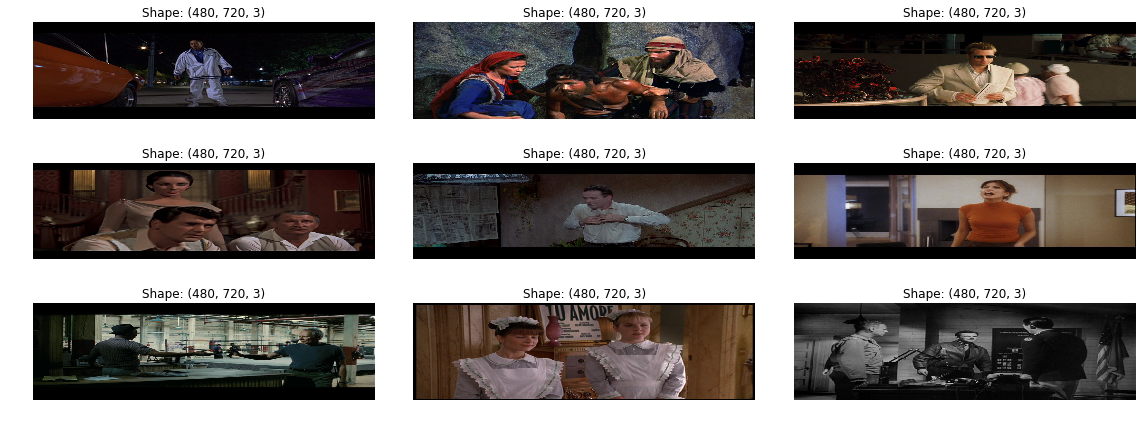

In [0]:
##Loading and validating some images
image_list = glob.glob('FLIC-full/images/*.jpg')[0:9]
plt.figure(figsize = (16,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(image_list[i])
    plt.imshow(img,aspect = 'auto')
    plt.axis('off')
    plt.title('Shape: '+str(img.shape))
    
plt.tight_layout()
plt.show()

In [0]:
##Preparing the dataset for modelling
##cropping

def image_cropping(image_id,joints,crop_pad_inf = 1.4,crop_pad_sup = 1.6,shift = 5,min_dim = 100):
    
    ##Loading the image
    image = cv.imread('FLIC-full/images/%s'%(image_id))
    ## convert joint list to array
    joints = np.asarray([int(float(p)) for p in joints])
    ## reshape joints to shape (7*2)
    joints = joints.reshape((len(joints)//2,2))
    ## transform joints to a list of x,y tuples
    posi_joints = [(j[0],j[1]) for j in joints if j[0]>0 and j[1] > 0]
    ## obtaining the bounding rectangle 
    x_loc,y_loc,width,height = cv.boundingRect(np.asarray([posi_joints]))
    if width < min_dim:
        width = min_dim
    if height < min_dim:
        height = min_dim
        
    ## expanding the rectangle
    inf,sup = crop_pad_inf,crop_pad_sup
    r = sup-inf
    
    ##defining the width padding
    pad_w_r = np.random.rand()*r+inf
    ## height padding
    pad_h_r = np.random.rand()*r+inf
    ## adjusting x,y,w,h by the defined padding
    x_loc -= (width*pad_w_r - width)/2
    y_loc -= (height*pad_h_r - height)/2
    width *= pad_w_r
    height *= pad_h_r
    
    ## shifting
    x_loc += np.random.rand() * shift * 2 - shift
    y_loc += np.random.rand() * shift * 2 - shift

    ## clipping
    x_loc, y_loc, width, height = [int(z) for z in [x_loc, y_loc, width, height]]
    x_loc = np.clip(x_loc, 0, image.shape[1] - 1)
    y_loc = np.clip(y_loc, 0, image.shape[0] - 1)
    width = np.clip(width, 1, image.shape[1] - (x_loc + 1))
    height = np.clip(height, 1, image.shape[0] - (y_loc + 1))
    image = image[y_loc: y_loc + height, x_loc: x_loc + width]

    ## joint shifting
    # adjust joint coordinates onto the padded image
    joints = np.asarray([(j[0] - x_loc, j[1] - y_loc) for j in joints])
    joints = joints.flatten()

    return image, joints

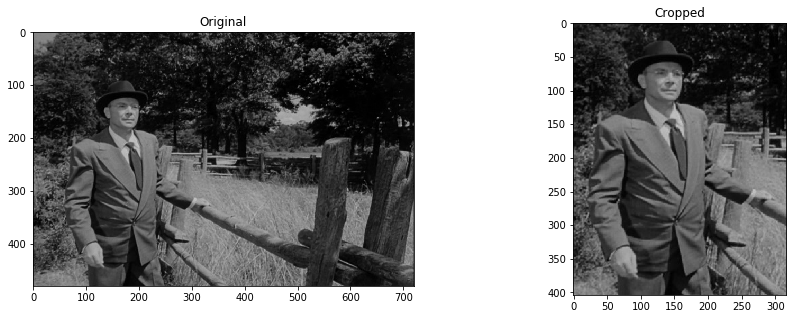

In [0]:
# plot the original image 
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(plt.imread('FLIC-full/images/'+train_image_ids[6]))

# plot the cropped image
image, joint = image_cropping(train_image_ids[6], train_joints[6])
plt.subplot(1,2,2)
plt.title('Cropped')
plt.imshow(image)

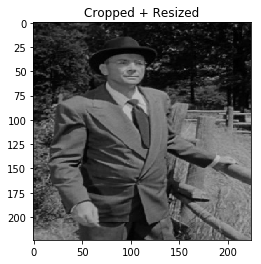

In [0]:
def image_resize(image, joints, new_size = 224):
    """Function resize cropped images"""
    orig_h, orig_w = image.shape[:2]
    joints[0::2] = joints[0::2] / float(orig_w) * new_size
    joints[1::2] = joints[1::2] / float(orig_h) * new_size
    image = cv.resize(image, (new_size, new_size), interpolation=cv.INTER_NEAREST)
    return image, joints
# plot resized image
image, joint = image_resize(image, joint)
plt.title('Cropped + Resized')
plt.imshow(image)

In [0]:
def plot_limb(img, joints, i, j, color):
    """Function to plot the limbs"""
    cv.line(img, joints[i], joints[j], (255, 255, 255), thickness=2, lineType=16)
    cv.line(img, joints[i], joints[j], color, thickness=1, lineType=16)
    return img

def plot_joints(img, joints, groundtruth=True, text_scale=0.5):
    """Function to draw the joints"""
    h, w, c = img.shape
    if groundtruth:
        # left hand to left elbow
        img = plot_limb(img, joints, 0, 1, (50, 155, 70))
        
        # left elbow to left shoulder
        img = plot_limb(img, joints, 1, 2, (50, 155, 70))
        
        # left shoulder to right shoulder
        img = plot_limb(img, joints, 2, 4, (50, 155, 70))
        
        # right shoulder to right elbow
        img = plot_limb(img, joints, 4, 5, (50, 155, 70))
        
        # right elbow to right hand
        img = plot_limb(img, joints, 5, 6, (50, 155, 70))
        
        # neck coordinate
        neck = tuple((np.array(joints[2]) + np.array(joints[4])) // 2)
        joints.append(neck)
        # neck to head
        img = plot_limb(img, joints, 3, 7, (50, 155, 70))
        joints.pop()

        # joints
        for j, joint in enumerate(joints):
            # plot joints
            cv.circle(img, joint, 5, (50, 155, 70), -1)
            # plot joint number black
            cv.putText(img, '%d' % j, joint, cv.FONT_HERSHEY_SIMPLEX, text_scale,
                       (0, 0, 0), thickness=2, lineType=16)
            # plot joint number white
            cv.putText(img, '%d' % j, joint, cv.FONT_HERSHEY_SIMPLEX, text_scale,
                       (255, 255, 255), thickness=1, lineType=16)

    else:
        # left hand to left elbow
        img = plot_limb(img, joints, 0, 1, (50, 70, 155))
        
        # left elbow to left shoulder
        img = plot_limb(img, joints, 1, 2, (50, 70, 155))
        
        # left shoulder to right shoulder
        img = plot_limb(img, joints, 2, 4, (50, 70, 155))
        
        # right shoulder to right elbow
        img = plot_limb(img, joints, 4, 5, (50, 70, 155))
        
        # right elbow to right hand
        img = plot_limb(img, joints, 5, 6, (50, 70, 155))
       
        # neck coordinate
        neck = tuple((np.array(joints[2]) + np.array(joints[4])) // 2)
        joints.append(neck)
        
        # neck to head
        img = plot_limb(img, joints, 3, 7, (50, 70, 155))
        joints.pop()

        # joints
        for j, joint in enumerate(joints):
            # plot joints
            cv.circle(img, joint, 5, (50, 70, 155), -1)
            # plot joint number black
            cv.putText(img, '%d' % j, joint, cv.FONT_HERSHEY_SIMPLEX, text_scale,
                       (0, 0, 0), thickness=3, lineType=16)
            # plot joint number white
            cv.putText(img, '%d' % j, joint, cv.FONT_HERSHEY_SIMPLEX, text_scale,
                       (255, 255, 255), thickness=1, lineType=16)

    return img

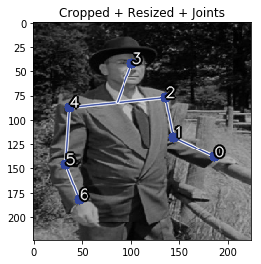

In [0]:
# plot joints on resized image
joints = joint.tolist()
joints = list(zip(joints[0::2], joints[1::2]))

plt.title('Cropped + Resized + Joints')
plt.imshow(plot_joints(image, joints, groundtruth=False, text_scale=0.5))

In [0]:
def model_data(image_ids, joints, train = True):
    """Function to generate train and test data."""
    if train:
        # empty list 
        train_img_joints = []
        
        # create train directory inside FLIC-full
        if not os.path.exists(os.path.join(os.getcwd(), 'FLIC-full/train')):
            os.mkdir('FLIC-full/train')

        for i, (image, joint) in enumerate(zip(image_ids, joints)):
            # crop the image using the joint coordinates
            image, joint = image_cropping(image, joint)
            
            # resize the cropped image to shape (224*224*3)
            image, joint = image_resize(image, joint)
            
            # save the image in train folder
            cv.imwrite('FLIC-full/train/train{}.jpg'.format(i), image)
            
            # store joints and image id/file name of the saved image in the initialized list
            train_img_joints.append(['train{}.jpg'.format(i)] + joint.tolist())
        
        # convert to a dataframe and save as a csv
        pd.DataFrame(train_img_joints).to_csv('FLIC-full/train/train_joints.csv', index=False, header=False)
    else:
        # empty list 
        test_img_joints = []
        
        # create test directory inside FLIC-full
        if not os.path.exists(os.path.join(os.getcwd(), 'FLIC-full/test')):
            os.mkdir('FLIC-full/test')
        
        for i, (image, joint) in enumerate(zip(image_ids, joints)):
            # crop the image using the joint coordinates
            image, joint = image_cropping(image, joint)
            
            # resize the cropped image to shape (224*224*3)
            image, joint = image_resize(image, joint)
            
            # save the image in test folder
            cv.imwrite('FLIC-full/test/test{}.jpg'.format(i), image)
            
            # store joints and image id/file name of the saved image in the initialized list
            test_img_joints.append(['test{}.jpg'.format(i)] + joint.tolist())
            
        # convert to a dataframe and save as a csv
        pd.DataFrame(test_img_joints).to_csv('FLIC-full/test/test_joints.csv', index=False, header=False)


model_data(train_image_ids, train_joints, train = True)
model_data(test_image_ids, test_joints, train = False)

In [0]:
##necessary keras imports
from keras.models import Sequential,Model
from keras.layers import Flatten,Dense,Dropout
from keras.optimizers import Adam
from keras import backend as K
from keras import applications

Using TensorFlow backend.


In [0]:
K.clear_session()

In [0]:
# Number of epochs
epochs = 10

# Batchsize
batch_size = 128

# Optimizer for the model
optimizer = Adam(lr=0.0001, beta_1=0.5)

# Shape of the input image
input_shape = (224, 224, 3)

# Batch interval at which loss is to be stores
store = 40

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# load the vgg16 model 
model = applications.vgg19.VGG19(weights = "imagenet", include_top=False, input_shape = input_shape)

# print summary of vgg16 model
model.summary()

80142336/80134624 [==============================] - 3s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool

In [0]:
# set layers as non trainable
for layer in model.layers[:-3]:
    layer.trainable = False


In [0]:
# Adding custom Layers
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)

# Dense layer with 14 neuron-s for predicting 14 numeric values
predictions = Dense(14, activation="relu")(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# print summary
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
# compile the model 
model_final.compile(loss = "mean_squared_error", optimizer = optimizer)

In [0]:
# load the train data
train = pd.read_csv('FLIC-full/train/train_joints.csv', header = None)

# split train into train and validation
train_img_ids, val_img_ids, train_jts, val_jts = train_test_split(train.iloc[:,0], train.iloc[:,1:], test_size=0.2, random_state=42)

# load validation images
val_images = np.array([cv.imread('FLIC-full/train/{}'.format(x)) for x in val_img_ids.values])

# convert validation images to dtype float 
val_images = val_images.astype(float)

In [0]:
def training(model, image_ids, joints ,val_images, val_jts, batch_size = 128, epochs=3, store = 40):
    # empty train loss list
    loss_lst = []
    
    # empty validation loss list
    val_loss_lst = []
    
    #counter
    count = 0
    count_lst = []
    
    # create shuffled batches
    batches = np.arange(len(image_ids)//batch_size)
    data_idx = np.arange(len(image_ids))
    random.shuffle(data_idx)
    print('......Training......')
    for epoch in range(epochs):
        for batch in (batches):
            # batch of training image ids
            imgs = image_ids[data_idx[batch*batch_size : (batch+1)*batch_size:]]
            
            # corresponding joints for the above images
            jts = joints[data_idx[batch*batch_size : (batch+1)*batch_size:]]
            
            # load the training image batch
            batch_imgs = np.array([cv.imread('FLIC-full/train/{}'.format(x)) for x in imgs])

            # fit model on the batch
            loss = model.train_on_batch(batch_imgs.astype(float), jts)
            
            if batch%store==0:
                # evaluate model on validation set
                val_loss = model.evaluate(val_images, val_jts, verbose = 0, batch_size=batch_size)
                
                # store train and val loss
                loss_lst.append(loss)
                val_loss_lst.append(val_loss)
                print('Epoch:{}, End of batch:{}, loss:{:.2f}, val_loss:{:.2f}'.format(epoch+1, batch+1, loss, val_loss))
                
                count_lst.append(count)
            else:
                print('Epoch:{}, End of batch:{}, loss:{:.2f}'.format(epoch+1, batch+1, loss))
            count+=1
    count_lst.append(count)
    loss_lst.append(loss)
    val_loss = model.evaluate(val_images, val_jts, verbose = 0, batch_size=batch_size)
    val_loss_lst.append(val_loss)
    print('Epoch:{}, End of batch:{}, VAL_LOSS:{:.2f}'.format(epoch+1, batch+1, val_loss))
    return model, loss_lst, val_loss_lst, count_lst

In [0]:
m, loss_lst, val_loss_lst, count_lst = training(model_final, train_img_ids.values, train_jts.values, val_images, val_jts.values, epochs = epochs, batch_size = batch_size, store = store)

......Training......
Instructions for updating:
Use tf.cast instead.
Epoch:1, End of batch:1, loss:14397.10, val_loss:10957.96
Epoch:1, End of batch:2, loss:10885.96
Epoch:1, End of batch:3, loss:4985.76
Epoch:1, End of batch:4, loss:11189.77
Epoch:1, End of batch:5, loss:3512.14
Epoch:1, End of batch:6, loss:4130.95
Epoch:1, End of batch:7, loss:3527.43
Epoch:1, End of batch:8, loss:2573.11
Epoch:1, End of batch:9, loss:2534.55
Epoch:1, End of batch:10, loss:1905.03
Epoch:1, End of batch:11, loss:1813.58
Epoch:1, End of batch:12, loss:1895.68
Epoch:1, End of batch:13, loss:1686.94
Epoch:1, End of batch:14, loss:1909.99
Epoch:1, End of batch:15, loss:1704.47
Epoch:1, End of batch:16, loss:1783.32
Epoch:1, End of batch:17, loss:1638.17
Epoch:1, End of batch:18, loss:1657.10
Epoch:1, End of batch:19, loss:1638.00
Epoch:1, End of batch:20, loss:1721.35
Epoch:1, End of batch:21, loss:1530.87
Epoch:1, End of batch:22, loss:1830.36
Epoch:1, End of batch:23, loss:1939.76
Epoch:1, End of batch

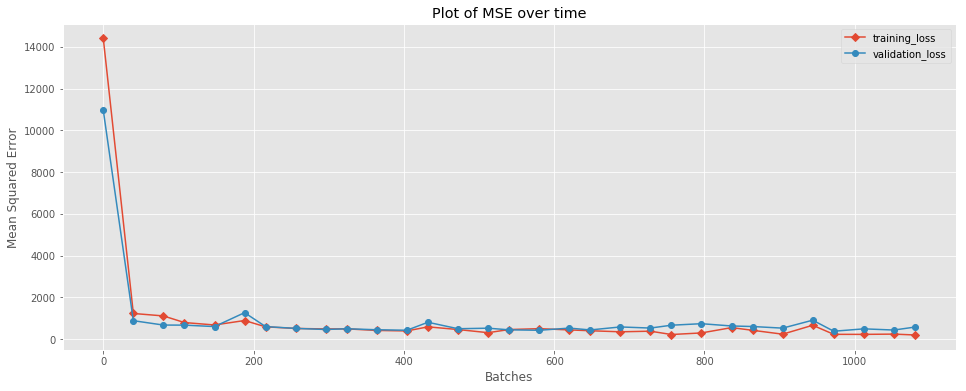

In [0]:
plt.style.use('ggplot')
plt.figure(figsize=(16, 6))
plt.plot(count_lst, loss_lst, marker='D', label = 'training_loss')
plt.plot(count_lst, val_loss_lst, marker='o', label = 'validation_loss')
plt.xlabel('Batches')
plt.ylabel('Mean Squared Error')
plt.title('Plot of MSE over time')
plt.legend(loc = 'upper right')
plt.show()

In [0]:
def test(model, nrows=200, batch_size=batch_size):
    # load the train data
    test = pd.read_csv('FLIC-full/test/test_joints.csv', header = None, nrows=nrows)
    test_img_ids = test.iloc[:,0].values
    
    # load validation images
    test_images = np.array([cv.imread('FLIC-full/test/{}'.format(x)) for x in test_img_ids])

    # convert validation images to dtype float 
    test_images = test_images.astype(float)
    
    # joints
    test_joints = test.iloc[:,1:].values
    
    # evaluate
    test_loss = model.evaluate(test_images, test_joints, verbose = 0, batch_size=batch_size)
    
    # predict
    predictions = model.predict(test_images, verbose = 0, batch_size=batch_size)
    # folder to save the results
    if not os.path.exists(os.path.join(os.getcwd(), 'FLIC-full/test_plot')):
        os.mkdir('FLIC-full/test_plot')
    
    for i, (ids, image, joint, pred) in enumerate(zip(test_img_ids, test_images, test_joints, predictions)):
        joints = joint.tolist()
        joints = list(zip(joints[0::2], joints[1::2]))
        # plot original joints
        image = plot_joints(image.astype(np.uint8), joints, groundtruth=True, text_scale=0.5)
        
        pred = pred.astype(np.uint8).tolist()
        pred = list(zip(pred[0::2], pred[1::2]))
        # plot predicted joints
        image = plot_joints(image.astype(np.uint8), pred, groundtruth=False, text_scale=0.5)
        # save resulting images with the same id
        plt.imsave('FLIC-full/test_plot/'+ids, image)
    return test_loss

In [0]:
# test and save results
test_loss = test(m)

# print test_loss
print('Test Loss:', test_loss)

Test Loss: 489.1448400878906


In [0]:
image_list = glob.glob('FLIC-full/test_plot/*.jpg')[32:40]
image_list

['FLIC-full/test_plot/test22.jpg',
 'FLIC-full/test_plot/test189.jpg',
 'FLIC-full/test_plot/test87.jpg',
 'FLIC-full/test_plot/test65.jpg',
 'FLIC-full/test_plot/test71.jpg',
 'FLIC-full/test_plot/test102.jpg',
 'FLIC-full/test_plot/test1.jpg',
 'FLIC-full/test_plot/test159.jpg']

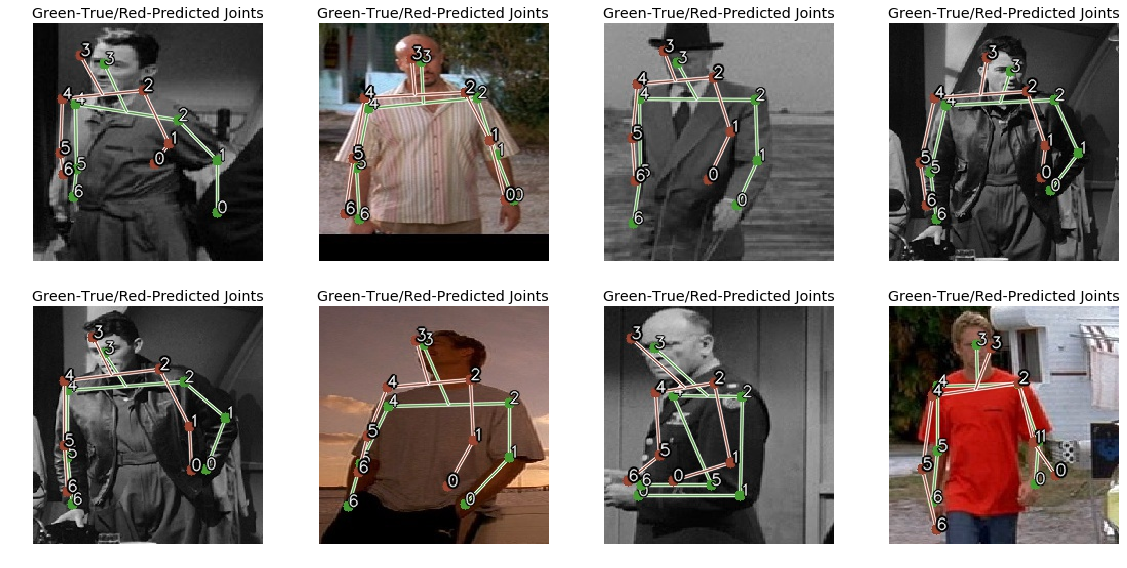

In [0]:
#image_list = glob.glob('FLIC-full/test_plot/*.jpg')[8:16]

plt.figure(figsize=(16,8))
for i in range(8):
    plt.subplot(2,4,(i+1))
    img = cv.imread(image_list[i])
    plt.imshow(img, aspect='auto')
    plt.axis('off')
    plt.title('Green-True/Red-Predicted Joints')

plt.tight_layout()
plt.show()

In [0]:
# save model
model_json = m.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights
m.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
